# Mapa Litoestratigráfico Preditivo - Diamantina (MG)

##### Trabalho de Conclusão de Curso - Geologia / IGC / UFMG

Autores: _Franco Naghetini_ & _Guilherme Silveira_

## Introdução

O trabalho tem como objetivo a produção de um **mapa litoestratigráfico preditivo 1:25.000**, a partir de dados de sensores remotos e dados do mapeamento geológico realizado pelos alunos da disciplina de Estágio Supervisionado do ano de 2018, na região de Diamantina. As predições das unidades litoestratigráficas serão realizadas, utilizando algoritmos de *Machine Learning* (aprendizado supervisionado).

O produto gráfico final (*i.e.*, mapa litoestratigráfico preditivo) pode ser utilizado como um meio de reconciliação entre os dados de mapeamento de campo e os sensores remotos. Nesse sentido, as inconsistências entre o mapa geológico e o mapa litoestratigráfico preditivo podem fornecer *insights* e orientar futuras campanhas de mapeamento na região de Diamantina (MG).

## Contexto geológico

##  Configurações iniciais

##### Importação de bibliotecas

In [1]:
import os                              # Sistema operacional
import pandas as pd                    # Manipulação de dataframes e series
import numpy as np                     # Operações numéricas
import matplotlib.pyplot as plt        # Visualização de dados
import seaborn as sns                  # Visualização de dados
import statistics as stats             # Ferramentas estatísticas
import scipy.stats as st               # Ferramentas estatísticas
import geopandas as gpd                # Manipulação de dataframes e series geoespaciais
import rasterio, folium                # Manipulação de rasters e mapas interativos
import warnings                        # Desabilitar avisos
warnings.filterwarnings("ignore")

%matplotlib inline

##### Importação do banco de dados

In [2]:
df_original = pd.read_csv("data/dados.csv",sep=",")

In [3]:
# criação de uma cópia (deep) do dataframe original
df = df_original.copy(deep = True)

## Visualização geoespacial

##### Polígono da área

In [4]:
# importação do polígono da área
pol = "shp/poligono_Sirgas.shp"
# transformação do polígono em (geo)dataframe
gdf = gpd.read_file(pol)
# modificação do crs (31983 -> 4326)
gdf_wgs = gdf.to_crs("EPSG:4326")

# mapa interativo
pol_map = folium.Map(location=[-18.3,-43.7], zoom_start=12,
                     tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                     attr = 'Google', name = 'Google Satellite', overlay = True, 
                     control = True)

# polígono sobre mapa interativo
folium.Choropleth(geo_data=gdf_wgs.geometry, fill_opacity=0.1).add_to(pol_map)

pol_map

##### Unidades litoestratigráficas

In [5]:
# importação do shapefile de unidades litoestratigráficas
lito = "shp/lito_Sirgas.shp"
# transformação do shapefile em (geo)dataframe
gdf = gpd.read_file(lito)
# modificação do crs (31983 -> 4326)
gdf_wgs = gdf.to_crs("EPSG:4326")

# mapa interativo
lito_map = folium.Map(location=[-18.3,-43.7], zoom_start=12,
                 tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
                 attr = 'Google', name = 'Google Satellite', overlay = True, 
                 control = True)

# unidades litoestratigráficas sobre mapa interativo
cplt = folium.Choropleth(geo_data=gdf_wgs, fill_opacity=0.4,
                  data=gdf_wgs,
                  columns=['Unidades','Id'],
                  key_on="feature.properties.Unidades",
                  locations=gdf_wgs.index,
                  legend_name='ID Litologia',
                  highlight=True,
                  fill_color="YlOrRd").add_to(lito_map)

cplt.geojson.add_child(folium.features.GeoJsonTooltip(['Unidades'],labels=False))

lito_map

## Análise geral dos dados

##### Forma dos dados

In [6]:
print("O banco de dados apresenta:")
print(f"   - {df.shape[0]} instâncias")
print(f"   - {df.shape[1]} colunas")

O banco de dados apresenta:
   - 11418 instâncias
   - 30 colunas


##### Sumário dos dados

In [7]:
datadict = pd.DataFrame(df.dtypes)
datadict["Valores Faltantes"] = df.isnull().sum()
datadict["Valores Únicos"] = df.nunique()
datadict["Contagem"] = df.count()
datadict = datadict.rename(columns = {0 : 'dType'})
datadict

,dType,Valores Faltantes,Valores Únicos,Contagem
LINE,object,0,228,11418
X,float64,0,95,11418
Y,float64,0,228,11418
X_UTM_23S_SIRGAS,float64,0,101,11418
Y_UTM_23S_SIRGAS,float64,0,238,11418
SIGNAL,float64,0,10694,11418
K_PERC,float64,0,509,11418
TH_PPM,float64,0,2557,11418
U_PPM,float64,0,850,11418
TC_EXP,float64,0,1547,11418


- Os dados geofísicos são do tipo *float64*;

- Os sensores remotos são do tipo *int64*;

- Não há valores faltantes no banco de dados;

- `ID_UNID` representa o *target*;

- `UNID` representa as siglas litoestratigráficas do *target* `ID_UNID`;

- `COD_UNID` representa os códigos litoestratigráficos do *target* `ID_UNID`;
    
- Todas as (possíveis) *features* são numéricas (*float* ou *int*).

## Variáveis globais & funções auxiliares

##### Variáveis globais

In [8]:
# features
FEAT = ['SIGNAL', 'K_PERC', 'TH_PPM', 'U_PPM', 'TC_EXP',
        'U_K', 'TH_K', 'U_TH', 'MDT', 'MDE', 'B01', 'B02',
        'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09',
        'LAND7_R', 'LAND7_G', 'LAND7_B']

# dados geofísicos
GF = ['SIGNAL', 'K_PERC', 'TH_PPM', 'U_PPM', 'TC_EXP',
      'U_K', 'TH_K', 'U_TH']

# canais radiométricos
RADIO = ['K_PERC', 'TH_PPM', 'U_PPM']

# sensores remotos
SR = ['MDT', 'MDE', 'B01', 'B02','B03', 'B04', 'B05',
      'B06', 'B07', 'B08', 'B09', 'LAND7_R', 'LAND7_G',
      'LAND7_B']

# coordenadas em sirgas
COORD = ['X_UTM_23S_SIRGAS', 'Y_UTM_23S_SIRGAS']

# dicionário litoestratigráfico
dic_lith = {}
for k, v1, v2 in zip(df['ID_UNID'].unique(), df['UNID'].unique(), df['COD_UNID'].unique()):
    dic_lith[k] = [v1, v2]

##### Parâmetros de gráficos

In [9]:
cm = 'jet'       # mapa de cores
mk = 's'         # estilo do marcador (quadrado)
sz = 1           # tamanho do marcador    
col = 'orange'   # cor dos histogramas
ec = 'black'     # cor das bordas dos histogramas

##### truncateVar(data :: dataframe, col :: string)

Realiza o truncamento de uma variável radiométrica `col`, tendo como referência os limiares inferior (*lower*) e superior (*upper*):

In [10]:
def truncateVar(data = None, col = None):

    lower = data[col].mean() / 10
    upper = data[col].quantile(0.995)
    var_trunc = []
    
    for v in data[col]:
        if v <= lower:
            v = lower
            var_trunc.append(v)
        elif v >= upper:
            v = upper
            var_trunc.append(v)
        else:
            var_trunc.append(v)
        
    return pd.Series(var_trunc)

##### sumStats(df :: dataframe)

Cria um sumário estatístico completo de um dataframe `df`.

In [11]:
def sumStats(df = None):
    stats = df.describe(percentiles = [0.1, 0.5, 0.995]).T

    stats['Amp'] = (df.max() - df.min()).tolist() # amplitude
    stats['S²'] = df.var().tolist() # variância
    stats['Cᵥ'] = (df.std() / df.mean()).tolist() # coeficiente de variação
    stats['Skew'] = df.skew().tolist() # coeficiente de assimetria
    stats = stats.rename(columns={'mean':'X̅','std':'S','min':'Min','max':'Max'})
    
    return stats[['X̅', '50%', 'Min','10%','99.5%','Max','Amp','S²','S','Cᵥ','Skew']]

##### plotBoxplots(cols :: list)

Plota `n` boxplots, sendo `n` o número de features presentes na lista `cols`.

In [12]:
def plotBoxplots(cols = None):
    
    n = len(cols)
    fig, axs = plt.subplots(n,1,figsize = (12, n * 2))
    
    for ax, f in zip(axs, cols):
        sns.boxplot(y = f, x = 'UNID', data = df, ax = ax)
        if f != cols[n - 1]:
            ax.axes.get_xaxis().set_visible(False)

##### sumByLito(f :: string)

Cria um sumário estatístico completo de uma feature `f` agrupado pelas unidades litoestratigráficas.

In [13]:
def sumByLito(f = None):
    
    table = df[['UNID', f]].groupby(by = 'UNID')
    stats = table.describe(percentiles = [0.1,0.995])
    
    return stats.T

##### histByLito(f :: string)

Plota histogramas de uma feature `f` agrupados pelas unidades litoestratigráficas.

In [14]:
def histByLito(f = None):
    
    df[f].hist(by = df['UNID'],
                 figsize = (9, 9),
                 edgecolor = ec,
                 color = col)

## Limpeza dos dados

##### Sumário estatístico das features geofísicas

In [15]:
df[GF].describe(percentiles = [0.10, 0.25, 0.50, 0.75, 0.995]).T

,count,mean,std,min,10%,25%,50%,75%,99.5%,max
SIGNAL,11418.0,0.048625,0.050442,0.00,0.011728,0.018873,0.033145,0.060799,0.272914,0.962399
K_PERC,11418.0,1.020346,0.970971,-0.20,0.190000,0.320000,0.640000,1.470000,4.719150,6.790000
TH_PPM,11418.0,9.040604,7.120726,0.15,2.600000,3.720000,6.450000,12.490000,34.077900,46.810000
U_PPM,11418.0,3.432387,1.798660,0.68,1.520000,1.990000,2.945000,4.650000,9.009150,10.780000
TC_EXP,11418.0,6.370295,3.983452,1.28,2.460000,3.120000,4.930000,9.190000,17.220000,19.280000
U_K,11418.0,5.380546,3.393909,0.97,2.120000,2.950000,4.420000,6.760000,18.119150,23.730000
TH_K,11418.0,12.626573,10.279783,2.23,5.310000,6.960000,9.840000,14.480000,74.419150,106.870000
U_TH,11418.0,0.479001,0.200478,0.11,0.270000,0.330000,0.450000,0.580000,1.290000,1.860000


In [16]:
# número de valores negativos de K_PERC
df.query('K_PERC < 0')['K_PERC'].count()

88

- Presença de 88 exemplos com valores negativos de `K_PERC`.

##### Truncamento das  variáveis radiométricas

- Nesta etapa, devemos truncar as variáveis radiométricas principais (*i.e.*, `K_PERC`, `TH_PPM` e `U_PPM`), utilizando a função auxiliar `truncateVar()`.

In [17]:
# Truncamento da features radiométricas (K_PERC, U_PPM, TH_PPM):
for r in RADIO:
    df[r] = truncateVar(data = df, col = r)

In [18]:
# sumário estatístico após o truncamento
df[GF].describe(percentiles = [0.10, 0.25, 0.50, 0.75, 0.995]).T

,count,mean,std,min,10%,25%,50%,75%,99.5%,max
SIGNAL,11418.0,0.048625,0.050442,0.000000,0.011728,0.018873,0.033145,0.060799,0.272914,0.962399
K_PERC,11418.0,1.019616,0.954047,0.102035,0.190000,0.320000,0.640000,1.470000,4.718372,4.719150
TH_PPM,11418.0,9.012547,7.000011,0.904060,2.600000,3.720000,6.450000,12.490000,34.057678,34.077900
U_PPM,11418.0,3.428294,1.784558,0.680000,1.520000,1.990000,2.945000,4.650000,9.008372,9.009150
TC_EXP,11418.0,6.370295,3.983452,1.280000,2.460000,3.120000,4.930000,9.190000,17.220000,19.280000
U_K,11418.0,5.380546,3.393909,0.970000,2.120000,2.950000,4.420000,6.760000,18.119150,23.730000
TH_K,11418.0,12.626573,10.279783,2.230000,5.310000,6.960000,9.840000,14.480000,74.419150,106.870000
U_TH,11418.0,0.479001,0.200478,0.110000,0.270000,0.330000,0.450000,0.580000,1.290000,1.860000


- Repare que o truncamento foi realizado com êxito. Após esse tratamento, os valores máximos das variáveis correspondem aos seus P99.5 originais, ao passo que seus valores mínimos correspondem um décimo das médias originais. 

## Análise Exploratória

### Visualização espacial das features

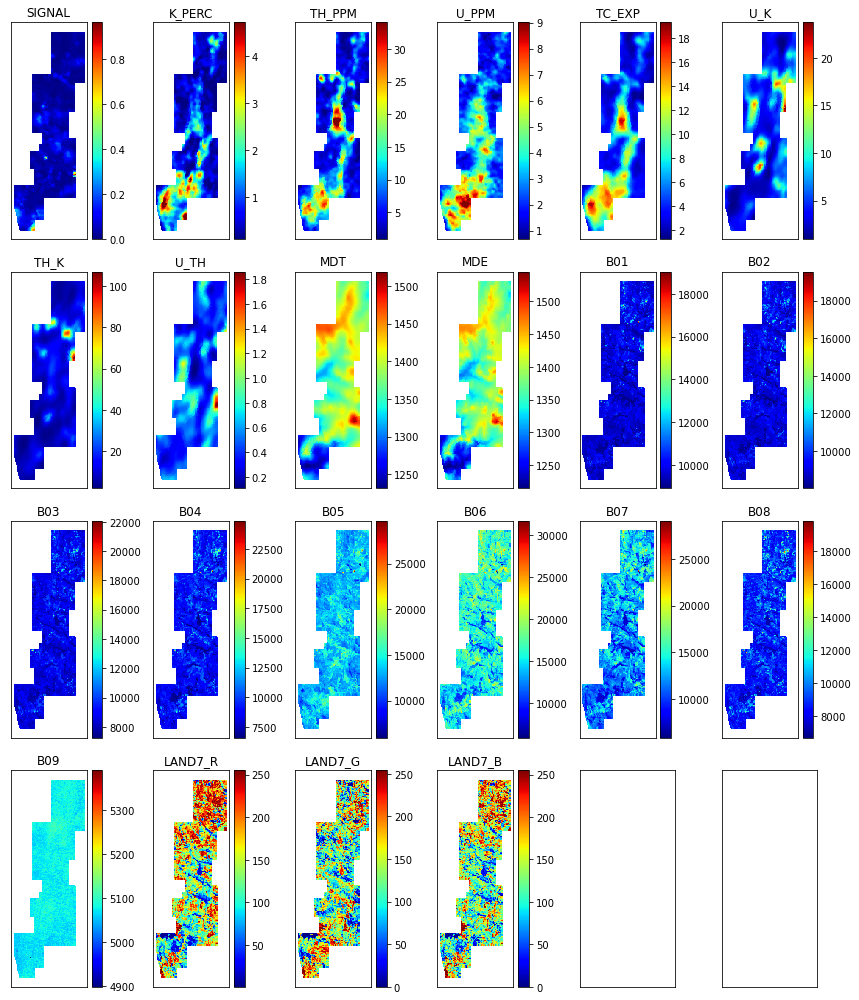

In [19]:
fig, axs = plt.subplots(nrows = 4, ncols = 6, figsize = (12, 14),
                        subplot_kw = {'xticks' : [], 'yticks' : []})

X, Y = COORD[0], COORD[1]

for ax, f in zip(axs.flat, FEAT):
    g = ax.scatter(data = df, x = X, y = Y, c = f, cmap = cm, s = sz, marker = mk)
    fig.colorbar(g, ax = ax)
    ax.set_title(str(f))

plt.tight_layout();

### Descrição univariada

##### Estatísticas dos dados geofísicos

In [20]:
sumStats(df = df[GF])

,X̅,50%,Min,10%,99.5%,Max,Amp,S²,S,Cᵥ,Skew
SIGNAL,0.048625,0.033145,0.000000,0.011728,0.272914,0.962399,0.962399,0.002544,0.050442,1.037373,4.250229
K_PERC,1.019616,0.640000,0.102035,0.190000,4.718372,4.719150,4.617115,0.910206,0.954047,0.935692,1.461631
TH_PPM,9.012547,6.450000,0.904060,2.600000,34.057678,34.077900,33.173840,49.000155,7.000011,0.776696,1.235449
U_PPM,3.428294,2.945000,0.680000,1.520000,9.008372,9.009150,8.329150,3.184647,1.784558,0.520538,0.838544
TC_EXP,6.370295,4.930000,1.280000,2.460000,17.220000,19.280000,18.000000,15.867890,3.983452,0.625317,0.877143
U_K,5.380546,4.420000,0.970000,2.120000,18.119150,23.730000,22.760000,11.518617,3.393909,0.630774,1.518701
TH_K,12.626573,9.840000,2.230000,5.310000,74.419150,106.870000,104.640000,105.673929,10.279783,0.814139,3.621432
U_TH,0.479001,0.450000,0.110000,0.270000,1.290000,1.860000,1.750000,0.040191,0.200478,0.418534,1.401608


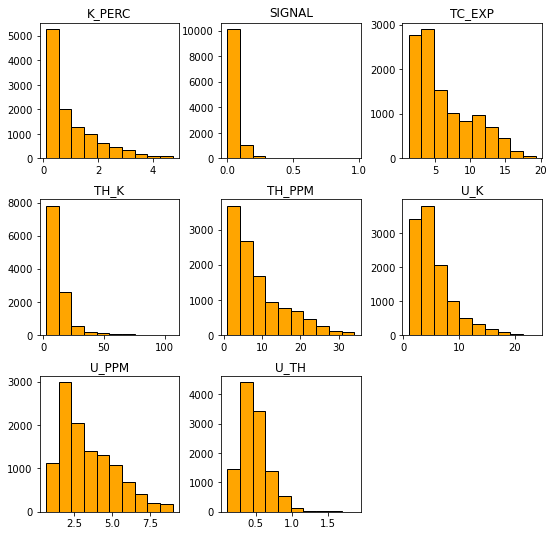

In [21]:
df[GF].hist(edgecolor = ec, color = col, figsize = (9,9), grid = False);

- Todas as features geofísicas apresentam distribuições assimétricas positivas;

- As features geofísicas tendem a ser as mais erráticas do banco de dados, com destaque para `SIGNAL` que, por sua vez, apresenta um Cᵥ ~ 1.04.

##### Estatísticas dos sensores remotos

In [22]:
sumStats(df = df[SR])

,X̅,50%,Min,10%,99.5%,Max,Amp,S²,S,Cᵥ,Skew
MDT,1376.713832,1383.765,1231.48,1309.447,1481.67555,1518.86,287.38,2.383816e+03,48.824333,0.035464,-0.751587
MDE,1371.491067,1379.000,1215.00,1299.000,1480.91500,1545.00,330.00,2.662541e+03,51.599815,0.037623,-0.781676
B01,9789.359345,9680.000,8905.00,9301.000,12100.06500,19037.00,10132.00,2.688853e+05,518.541536,0.052970,2.704648
B02,9127.988965,9012.000,8010.00,8523.000,11752.83000,19540.00,11530.00,3.767398e+05,613.791292,0.067243,2.429767
B03,8805.247154,8656.000,7272.00,8004.000,12105.57500,22051.00,14779.00,6.268228e+05,791.721443,0.089915,2.342953
B04,9057.911105,8924.000,6613.00,7781.700,13584.02500,24846.00,18233.00,1.360990e+06,1166.614752,0.128795,1.555522
B05,13390.707304,13203.000,5960.00,11855.000,17983.66000,29667.00,23707.00,2.014171e+06,1419.215064,0.105985,0.912569
B06,15849.828254,15917.500,5962.00,12605.400,22480.51500,31637.00,25675.00,6.095484e+06,2468.903304,0.155768,-0.011219
B07,12359.669207,12247.000,5885.00,9496.500,19146.06500,29052.00,23167.00,5.197637e+06,2279.832696,0.184457,0.312071
B08,8833.474864,8675.500,6703.00,7789.000,13067.70500,19822.00,13119.00,1.002425e+06,1001.211582,0.113343,2.106471


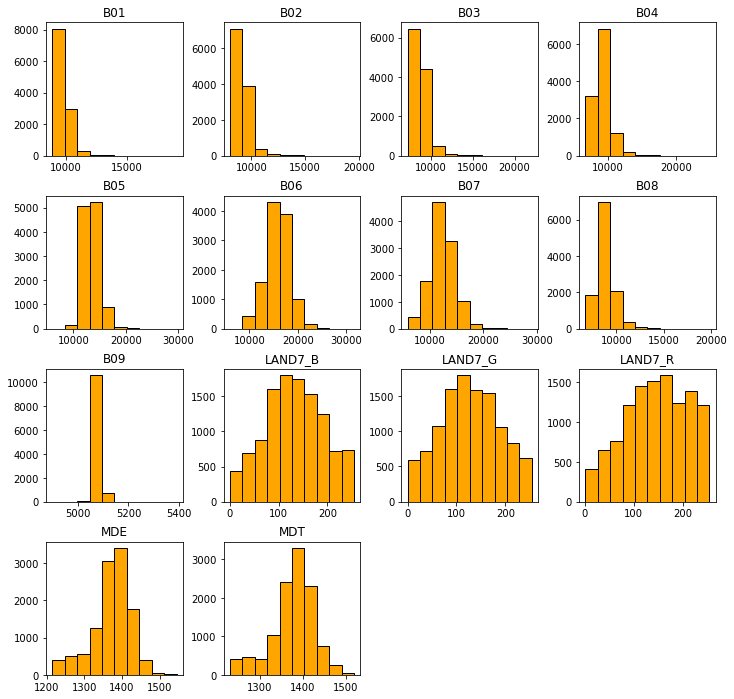

In [23]:
df[SR].hist(edgecolor = ec, color = col, figsize = (12,12), grid = False);

- A grande maioria dos sensores remotos apresentam distribuições assimétricas positivas ou quase simétricas;

- Apenas três features apresentam distribuições assimétricas negativas: `MDE`, `MDT` e `LAND7_R`.

- Em geral, os sensores remotos tendem a ser pouco erráticos, com destaque para `B09` que, por sua vez, apresenta um Cᵥ ~ 0.03.

##### Análise da dispersão das features

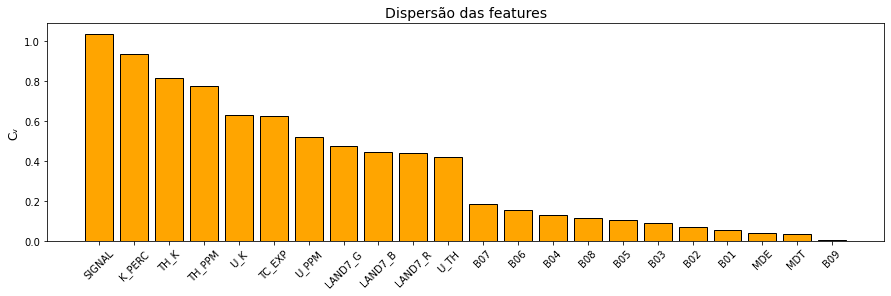

In [24]:
disp = sumStats(df = df[FEAT]).sort_values(by = 'Cᵥ', ascending = False)['Cᵥ']

plt.figure(figsize = (15,4))

plt.bar(x = disp.index, height = disp.values,
       color = col, edgecolor = ec)

plt.title("Dispersão das features", size = 14)
plt.xticks(rotation = 45)
plt.ylabel("Cᵥ", size = 12);

- Os sensores remotos tendem a ser muito pouco erráticos (Cᵥ < 0.2), com exceção das features `LAND7_R`, `LAND7_G` e `LAND7_B` que, por sua vez, encontram-se entre as 10 features mais erráticas;

- Os dados geofísicos são, em geral os que apresentam maior dispersão, com exceção da razão `U_TH`.

##### Gráfico de barras unidades litoestratigráficas

In [25]:
# Criação de dataframe com as variáveis utilizadas nos gráfico
df_lito_count = pd.DataFrame(df['UNID'].value_counts())                             # Criação do dataframe
total_lito_count = df['UNID'].value_counts().sum()                                  # Contagem total
df_lito_count['UNID_PERC'] = (df_lito_count['UNID'] / total_lito_count) * 100       # Criação de coluna de frequência percentual
freq_abs = df_lito_count['UNID']                                                    # Variável de frequência absoluta
freq_perc = df_lito_count['UNID_PERC'].round(2)                                     # Variável de frequência percentual

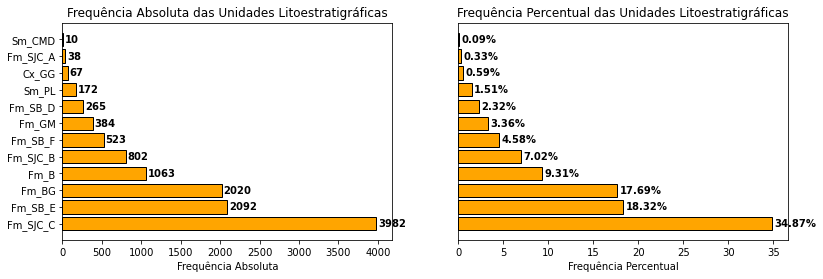

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,4))

# Gráfico frequência absoluta
ax1.barh(list(df_lito_count.index),
         freq_abs,
         color = col,
         edgecolor = ec)

for i, v in enumerate(freq_abs):
    ax1.text(v + 20, i, str(v), va='center', fontweight='bold')
    
plt.setp(ax1,title="Frequência Absoluta das Unidades Litoestratigráficas",
         xlabel="Frequência Absoluta")


# Gráfico frequência percentual
ax2.barh(list(df_lito_count.index),
         freq_perc,
         color = col,
         edgecolor = ec)

ax2.axes.get_yaxis().set_visible(False)

for i, v in enumerate(freq_perc):
    ax2.text(v + 0.25, i, str(v) + "%", va='center', fontweight='bold')
    
plt.setp(ax2,title="Frequência Percentual das Unidades Litoestratigráficas",
         xlabel="Frequência Percentual");

- As 3 unidades litoestratigráficas mais frequentes (`Fm_SJC_C`, `Fm_SB_E` e `Fm_BG`) representam mais de 70% do total de ocorrências;

- Portanto, as classes estão claramente desbalanceadas e algumas abordagens serão conduzidas posteriormente para lidar com esse problema.

### Descrição Bivariada

##### Mapas de calor - coeficiente de correlação de Spearman

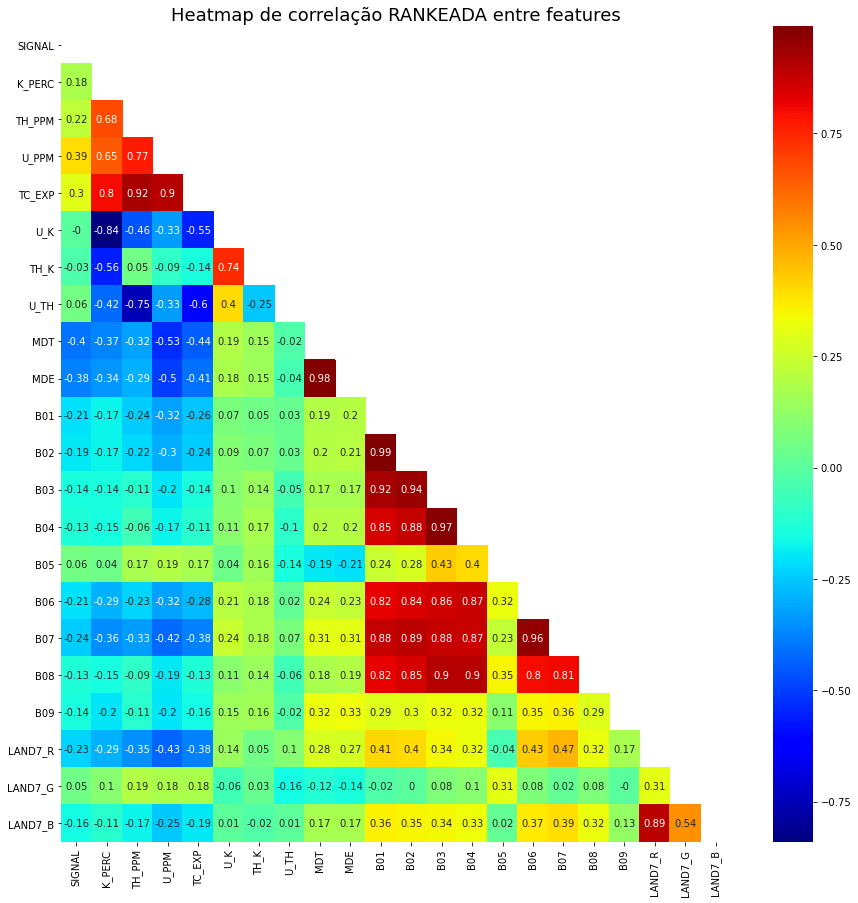

In [27]:
mx_spear = df[FEAT].corr(method = 'spearman').round(2)

mask = np.triu(np.ones_like(mx_spear, dtype = np.bool))

plt.figure(figsize = (15, 15))
plt.title ('Heatmap de correlação RANKEADA entre features', size = 18)

ax = sns.heatmap(
                 mx_spear,
                 annot = True,
                 cmap = cm,
                 cbar = True,
                 mask = mask
                )

##### Mapas de calor - Coeficiente de Correlação de Pearson

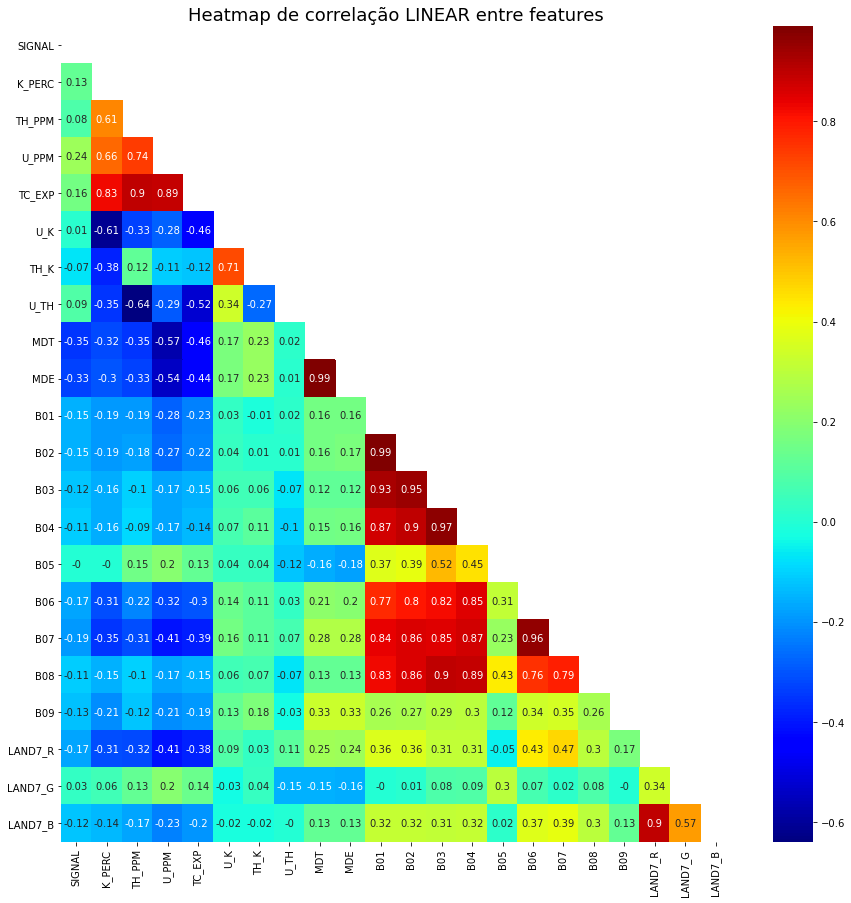

In [28]:
mx_pear = df[FEAT].corr().round(2)

mask = np.triu(np.ones_like(mx_pear, dtype = np.bool))

plt.figure(figsize = (15, 15))
plt.title ('Heatmap de correlação LINEAR entre features', size = 18)

ax = sns.heatmap(
                 mx_pear,
                 annot = True,
                 cmap = cm,
                 cbar = True,
                 mask = mask
                )

- As features `U_PPM`, `TH_PPM` e `K_PERC` apresentam correlações lineares positivas médias a fortes entre si;

- As features `U_PPM`, `TH_PPM` e `K_PERC` apresentam forte correlação linear positiva com a variável `TC_EXP`, o que já era esperado;

- A feature `SIGNAL` não apresenta correlação (linear ou monotônica) significativa com nenhuma outra feature;

- As features Landsat 8 apresentam fortíssimas correlações lineares entre si. Esse fato pode implicar em multicolinearidade e deve ser tratado cautelosamente caso um algoritmo linear seja utilizado.As únicas exceções são `B05` e `B09`;

- As features `MDE` e `MDT` são particamente idênticas. Apenas uma delas deve ser selecionada para treinar os algoritmos;

- A feature `MDT` apresenta uma correlação linear negativa média com `U_PPM`. Esse fato é interessante e deve ser investigado!

##### Features geofísicas x target

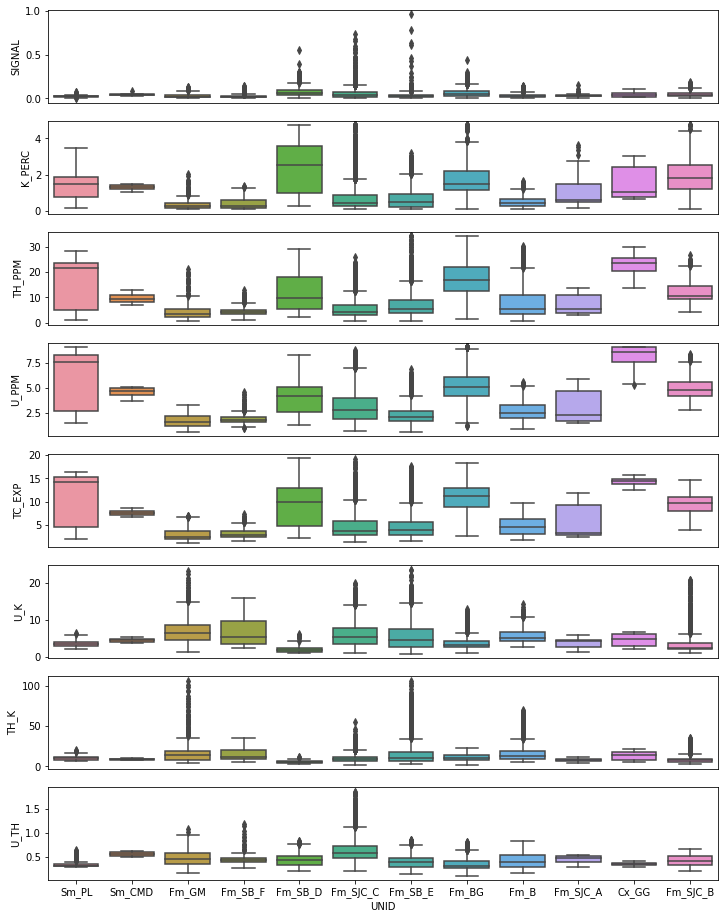

In [29]:
plotBoxplots(cols = GF);

- As features radiométricas apresentam uma variabilidade significativa quando agrupadas pelas unidades litoestratigráficas. Essas variáveis possivelmente serão as **mais importantes** para treinar os modelos;

- Em contrapartida, a variável magnetométrica `SIGNAL` apresenta-se praticamente estacionária quando agrupada pelas unidades.

##### Sensores remotos x target

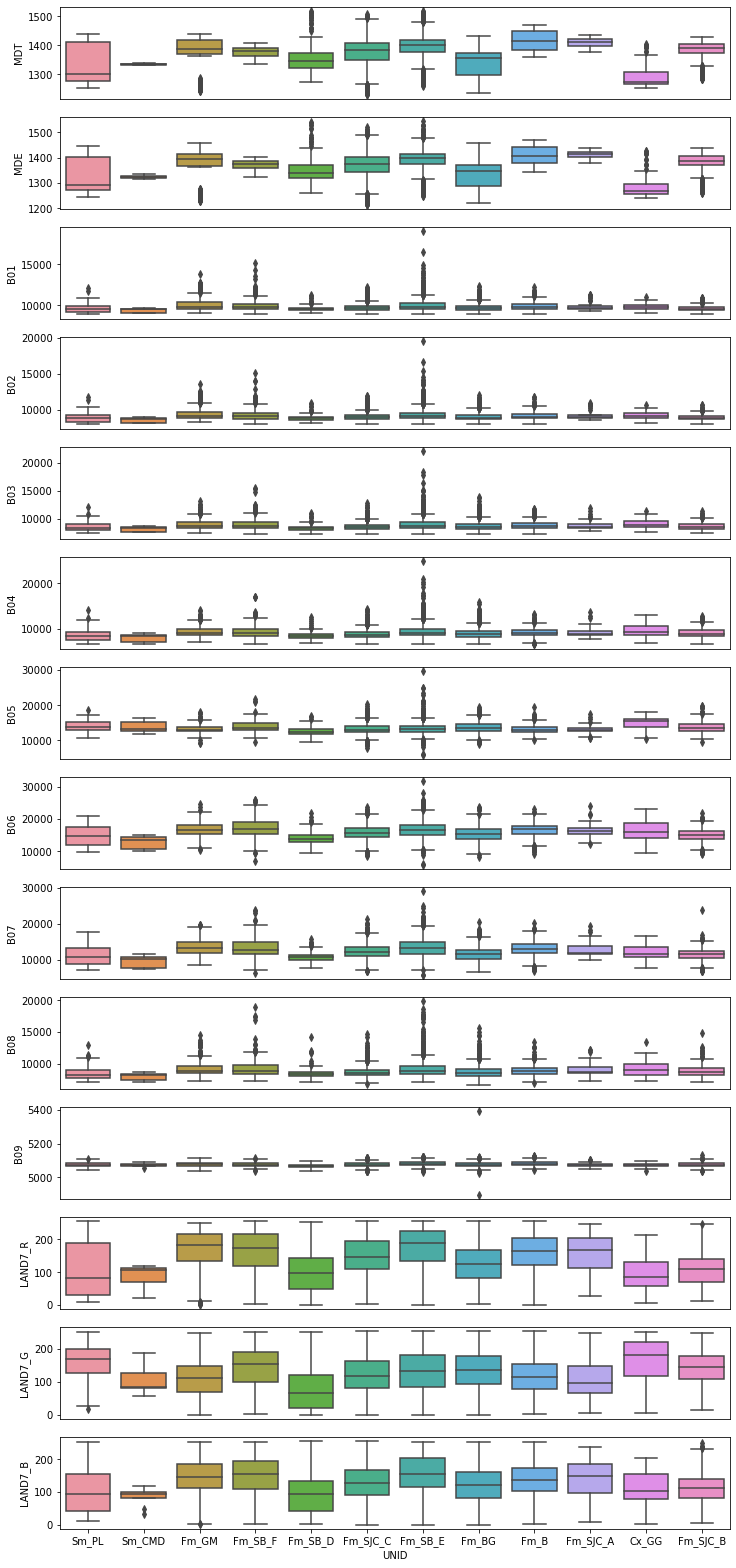

In [30]:
plotBoxplots(cols = SR);

- As features Landsat 8 apresentam uma variabilidade extremamente baixa quando agrupadas pelas unidades. Nesse sentido, possivelmente, essas variáveis não serão úteis para treinar os modelos;

- Em contrapartida, as features geofísicas, juntamente com `MDE` / `MDT`, `LAND7_R`, `LAND7_G` e `LAND7_B`, apresentam uma dispersão significativa quando agrupadas pelas unidades. Essas variáveis possivelmente contribuirão positivamente para as predições.

##### Estatísticas de K (%) por unidade litoestratigráfica

In [31]:
sumByLito(f = 'K_PERC')

UNID              Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
K_PERC count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
       mean    1.530149     0.506757     1.729954    0.379748    2.446235   
       std     0.809286     0.263806     0.878516    0.325887    1.403461   
       min     0.670000     0.102035     0.102035    0.102035    0.320000   
       10%     0.710000     0.210000     0.800000    0.110000    0.568000   
       50%     1.050000     0.450000     1.520000    0.270000    2.520000   
       99.5%   2.990400     1.417600     4.719150    1.739550    4.719150   
       max     3.030000     1.640000     4.719150    2.060000    4.719150   

UNID              Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
K_PERC count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
       mean      0.714696    0.432153   1.232105    1.897234     0.793884   
       std       0.636324    0.310973   0.972995    1.031912     0.869994   
       min       0.102035    0.102035   0.170000    0.102035     0.102035   
       10%       0.130000    0.110000   0.437000    0.391000     0.180000   
       50%       0.490000    0.320000   0.610000    1.850000     0.440000   
       99.5%     2.820000    1.341700   3.611500    4.719150     4.612850   
       max       3.180000    1.400000   3.630000    4.719150     4.719150   

UNID             Sm_CMD       Sm_PL  
K_PERC count  10.000000  172.000000  
       mean    1.323000    1.442733  
       std     0.159308    0.821266  
       min     1.040000    0.210000  
       10%     1.139000    0.321000  
       50%     1.340000    1.520000  
       99.5%   1.499100    3.418700  
       max     1.500000    3.470000

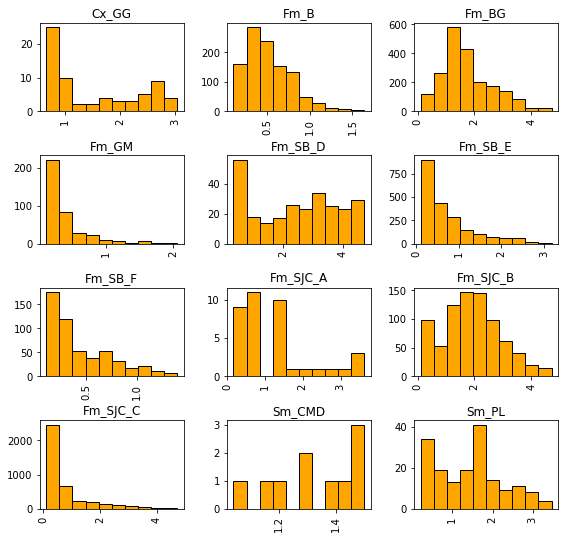

In [32]:
histByLito(f = 'K_PERC');

- As unidades que apresentam MAIORES concentrações de `K_PERC` são **Fm_SB_D** e **Fm_SJC_B**;

- As unidades que apresentam MENORES concentrações de `K_PERC` são **Fm_GM** e **Fm_SB_F**.

##### Estatísticas de U (ppm) por unidade litoestratigráfica

In [33]:
sumByLito(f = 'U_PPM')

UNID             Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
U_PPM count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
      mean    8.048590     2.671477     5.201776    1.723854    4.091132   
      std     1.123448     0.927466     1.407053    0.639106    1.654864   
      min     5.260000     0.890000     1.230000    0.680000    1.330000   
      10%     5.976000     1.590000     3.430000    0.950000    1.622000   
      50%     8.580000     2.510000     5.140000    1.605000    4.220000   
      99.5%   9.009150     5.193800     9.009150    3.183400    7.913600   
      max     9.009150     5.550000     9.009150    3.280000    8.260000   

UNID             Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
U_PPM count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
      mean      2.330497    1.932084   3.272632    4.941858     3.129367   
      std       0.936176    0.473562   1.656748    1.003734     1.555412   
      min       0.680000    0.990000   1.490000    2.790000     0.750000   
      10%       1.420000    1.450000   1.530000    3.740000     1.450000   
      50%       2.160000    1.860000   2.320000    4.830000     2.780000   
      99.5%     6.039950    4.151900   5.864450    8.149350     8.080950   
      max       6.830000    4.580000   5.870000    8.340000     8.750000   

UNID            Sm_CMD       Sm_PL  
U_PPM count  10.000000  172.000000  
      mean    4.598000    5.993007  
      std     0.489144    2.797706  
      min     3.660000    1.560000  
      10%     3.975000    2.140000  
      50%     4.745000    7.605000  
      99.5%   5.126400    9.009150  
      max     5.130000    9.009150

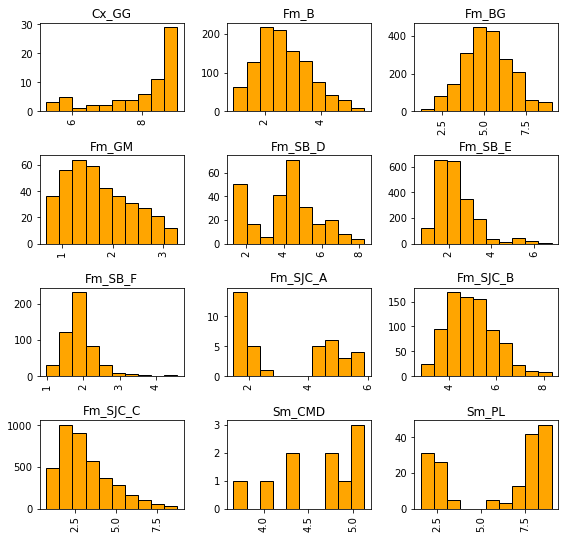

In [34]:
histByLito(f = 'U_PPM');

- As unidades que apresentam MAIORES concentrações de `U_PPM` são **Cx_GG** e **Fm_BG**;

- As unidades que apresentam MENORES concentrações de `U_PPM` são **Fm_GM** e **Fm_SB_F**.

##### Estatísticas de Th (ppm) por unidade litoestratigráfica

In [35]:
sumByLito(f = 'TH_PPM')

UNID              Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
TH_PPM count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
       mean   22.975672     7.865703    17.449252    4.520919   11.916642   
       std     3.797475     5.932064     6.969378    3.687290    7.481756   
       min    13.870000     0.904060     1.660000    0.904060    2.200000   
       10%    18.066000     2.362000     9.310000    1.345000    3.578000   
       50%    23.500000     5.520000    17.040000    3.375000    9.630000   
       99.5%  29.808500    28.277700    34.077900   19.395900   27.829600   
       max    29.990000    30.320000    34.077900   21.160000   29.120000   

UNID              Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
TH_PPM count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
       mean      7.011018    4.701243   7.523158   12.193379     5.717703   
       std       4.983653    2.037439   3.869736    4.390383     4.230976   
       min       0.910000    1.080000   3.050000    4.100000     0.904060   
       10%       2.740000    2.752000   3.344000    8.173000     2.101000   
       50%       5.480000    4.240000   5.460000   10.490000     4.320000   
       99.5%    30.389750   11.657800  13.550800   24.049750    21.050450   
       max      34.077900   12.920000  13.610000   26.580000    26.140000   

UNID             Sm_CMD       Sm_PL  
TH_PPM count  10.000000  172.000000  
       mean    9.738000   16.320814  
       std     2.039917    9.277814  
       min     6.840000    1.290000  
       10%     7.569000    2.756000  
       50%     9.310000   21.630000  
       99.5%  12.832800   28.165100  
       max    12.840000   28.490000

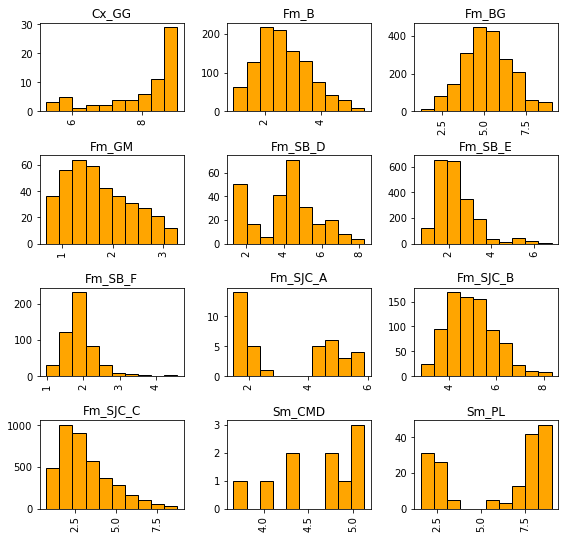

In [36]:
histByLito(f = 'U_PPM');

- As unidades que apresentam MAIORES concentrações de `TH_PPM` são **Cx_GG** e **Fm_BG** (mesmas do `U_PPM`);

- As unidades que apresentam MENORES concentrações de `TH_PPM` são **Fm_GM** e **Fm_SB_F** (mesmas do `U_PPM`).

##### Estatísticas de contagem total (μR/h) por unidade litoestratigráfica

In [37]:
sumByLito(f = 'TC_EXP')

UNID              Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
TC_EXP count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
       mean   14.321194     4.876453    10.888317    2.998047    9.683321   
       std     0.754621     1.941457     3.132546    1.379104    4.856235   
       min    12.470000     1.810000     2.700000    1.280000    2.230000   
       10%    13.256000     2.470000     6.689000    1.533000    3.100000   
       50%    14.450000     4.710000    11.280000    2.505000    9.860000   
       99.5%  15.727500     9.568300    17.939550    6.980850   19.141200   
       max    15.810000     9.770000    18.290000    7.020000   19.280000   

UNID              Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
TC_EXP count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
       mean      4.618815    3.233537   6.176316    9.535449     4.945826   
       std       2.482388    1.063460   3.555941    2.313963     3.196253   
       min       1.540000    1.520000   2.480000    3.940000     1.410000   
       10%       2.420000    2.202000   2.721000    6.262000     2.380000   
       50%       3.950000    2.860000   3.290000    9.780000     3.660000   
       99.5%    15.934500    6.646300  11.860400   14.549850    14.790450   
       max      17.690000    7.320000  11.890000   14.760000    19.080000   

UNID             Sm_CMD       Sm_PL  
TC_EXP count  10.000000  172.000000  
       mean    7.648000   10.898372  
       std     0.662182    5.467303  
       min     6.650000    2.120000  
       10%     6.929000    2.704000  
       50%     7.630000   14.345000  
       99.5%   8.675600   16.223200  
       max     8.690000   16.360000

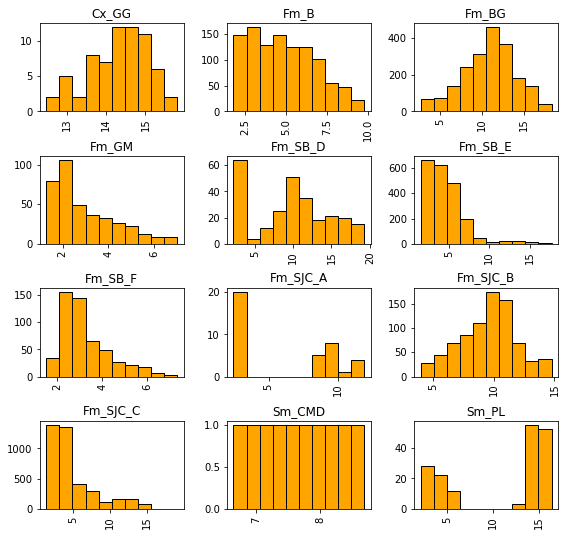

In [38]:
histByLito(f = 'TC_EXP');

- As unidades que apresentam MAIORES concentrações de `TC_EXP` são **Cx_GG** e **Fm_BG** (mesmas do `U_PPM` e `TH_PPM`);

- As unidades que apresentam MENORES concentrações de `TC_EXP` são **Fm_GM** e **Fm_SB_F** (mesmas do `U_PPM` e `TH_PPM`);

- OBS.: a distribuição uniforme apresentada por **Sm_CMD** ocorre em função da baixa densidade amostral dessa unidade (10 valores e 10 *bins*).

##### Estatísticas de sinal análitico (nT/m) por unidade litoestratigráfica

In [39]:
sumByLito(f = 'SIGNAL')

UNID              Cx_GG         Fm_B        Fm_BG       Fm_GM     Fm_SB_D  \
SIGNAL count  67.000000  1063.000000  2020.000000  384.000000  265.000000   
       mean    0.043463     0.030320     0.061803    0.029581    0.083216   
       std     0.026423     0.023523     0.051433    0.024113    0.070785   
       min     0.012960     0.001470     0.001725    0.003204    0.008845   
       10%     0.018700     0.010169     0.014981    0.007671    0.027161   
       50%     0.036008     0.023046     0.046121    0.020791    0.061637   
       99.5%   0.105040     0.131177     0.248779    0.121511    0.361081   
       max     0.105082     0.144330     0.437557    0.129563    0.550258   

UNID              Fm_SB_E     Fm_SB_F   Fm_SJC_A    Fm_SJC_B     Fm_SJC_C  \
SIGNAL count  2092.000000  523.000000  38.000000  802.000000  3982.000000   
       mean      0.036868    0.025665   0.036983    0.047027     0.056950   
       std       0.044899    0.023980   0.029665    0.031436     0.059477   
       min       0.001291    0.003913   0.004470    0.004734     0.000000   
       10%       0.011163    0.008551   0.015105    0.014868     0.012374   
       50%       0.025521    0.017815   0.026017    0.038828     0.037942   
       99.5%     0.192202    0.128163   0.146022    0.173542     0.370855   
       max       0.962399    0.142053   0.155228    0.190429     0.743154   

UNID             Sm_CMD       Sm_PL  
SIGNAL count  10.000000  172.000000  
       mean    0.045278    0.028506  
       std     0.014826    0.011342  
       min     0.028408    0.003918  
       10%     0.030325    0.016186  
       50%     0.042953    0.026073  
       99.5%   0.080198    0.072230  
       max     0.081434    0.076001

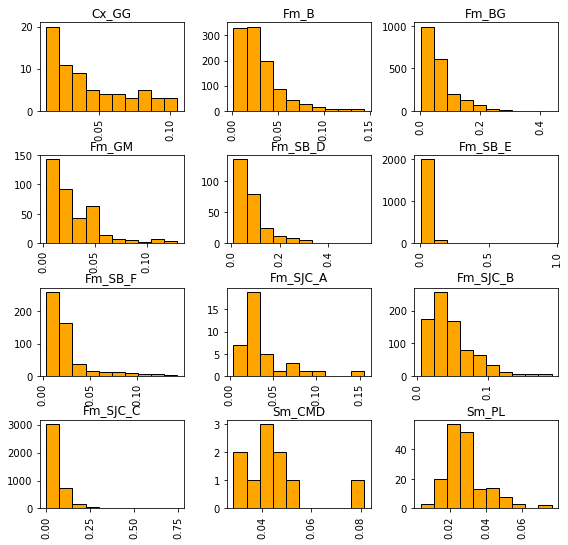

In [40]:
histByLito(f = 'SIGNAL');

- As unidades que apresentam MAIORES concentrações de `SIGNAL` são **Fm_SB_D** e **Fm_BG**;

- As unidades que apresentam MENORES concentrações de `SIGNAL` são **Fm_SB_F** e **Sm_PL**.